In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import mpmath as mp

#### 1. Read production data from CSV file

In [2]:
#Extract api#, monthly_oil and date from Drillinginfo File
df = pandas.read_csv('Monthly_Production.CSV')
oil = np.array(df['Monthly Oil'].values)
api_well = np.array(df['API/UWI'].values)
pro_month = np.array(df['Monthly Production Date'].values)
unique_ids=len(np.unique(api_well))
print('Total number of wells are: {}'.format (unique_ids)) # Confirming all 153 wells are read into memory

Total number of wells are: 153


#### 2. Data Preparation
* Split each individual well's production data into an array
* Pick a well, and plot the original production data
* Take first 12 month of log(oil rate) as training data

In [3]:
ID_0 = api_well[0]
i=0
j=0
k=0
oil_array=np.zeros((unique_ids,36),dtype=int)
for ID in api_well:
    if ID==ID_0:
        oil_array[i,j]=oil[k]
        j=j+1
    else:
        ID_0=ID
        i=i+1
        j=0
    k=k+1 

**Selecting well number 3 production data for fitting**

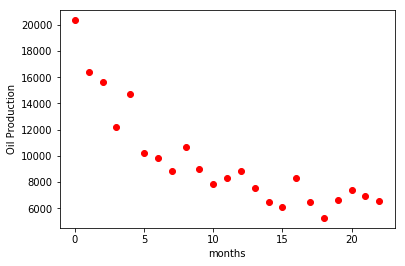

In [4]:
cur = oil_array[3]
rec_month = np.count_nonzero(cur)
fig = plt.figure();aa = plt.axes()
aa.plot(cur[:rec_month],'ro'); 
aa.set(xlabel='months', ylabel='Oil Production');  

#### Selecting log transformed first twelve months of data for fitting

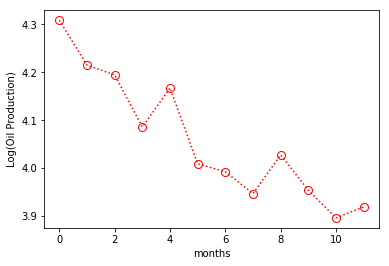

In [5]:
data = np.log10(cur[0:12])
marker_style = dict(color='r', linestyle=':', marker='o',
                    markersize=8, markerfacecoloralt='gray')
fig = plt.figure();aa = plt.axes()
aa.plot(data,'ro',fillstyle='none',**marker_style);
aa.set(xlabel='months', ylabel='Log(Oil Production)');  

## MCMC Parameter Estimation of Decline Curve Models
There are many models to estimate the oil production decline curve. **Arps** and **Jacobi theta functions** are most popular of them. MCMC parameter estimation comprises of the following steps.
  * Define posterior function
  * Initialize the chain
  * Sampling from posterior distribution
### ARPs
ARPs model is popular becasue of its application to various production methods and ease of implimentation. Arps correlation is provided as below:
$$Q_t=Q_i(1+bD_it)^{-\frac{1}{b}}$$
Where $Q_i$, $b$, $D_i$ are the parameters to be fitted. Which represent initial production from the well, Arps decline exponent and Arps's initial decline rate respectively.


In [6]:
def Arps(t,Di,logQi,b):
    Qt = logQi - 1/b*np.log10(1+b*Di*t)
    return Qt

In [7]:
def post(Di,logQi,b,sigma,t,data):
    like = np.prod(np.exp(-np.power(Arps(t,Di,logQi,b)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [8]:
#initialization
#tt_test = np.linspace(0,23,24)
tt_test = np.linspace(1,24,24)
Di = 0.5
logQi = 4
b = 0.5
t=np.arange(0,12)
logQi = data[0]
Niter = 100000
chain = np.zeros((Niter,3))
chain[0,0] = Di # Initialize the chain with first guess
chain[0,1] = logQi
chain[0,2] = b

sigma=0.05

In [9]:
  for ii in np.arange(Niter-1):
        if ii%50000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        b     = chain[ii,2] 
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        b_p     = b + np.random.normal(loc=0.0,scale=0.1,size=1)
        
        if Di_p < 0.1 or Di_p>50 or b_p<0 or b_p>=2 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post(Di_p,logQi_p,b_p,sigma,t,data) / post(Di,logQi,b,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = b_p 
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter));

iteration 0


C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


iteration 50000
Sampling finished at iteration 100000


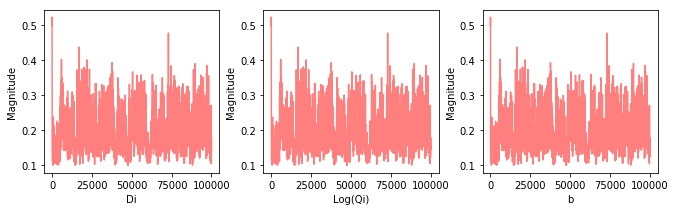

In [10]:
plt.rcParams['figure.figsize'] = (11, 3)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

ax = fig.add_subplot(1, 3, 1)
ax.plot(chain[:,0],color='r',alpha=.5);
ax.set(xlabel='Di', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 2)
ax.plot(chain[:,0],color='r',alpha=.5);
ax.set(xlabel='Log(Qi)', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 3)
ax.plot(chain[:,0],color='r',alpha=.5);
ax.set(xlabel='b', ylabel='Magnitude'); 

Chains seem to converge after 10000 iterations.

In [11]:
chain = chain[10000:]#burnin
#np.size(chain[:,1])

#### ARPs-Posterior Summary
Mean values of the fitted parameters

In [12]:
a_Di=round(np.mean(chain[:,0]),3)
a_logQi=round(np.mean(chain[:,1]),3)
a_b=round(np.mean(chain[:,2]),3)
print('Mean of D     ={}'.format(Di))
print('Mean of logQi ={}'.format(logQi))
print('Mean of b     ={}'.format(b))

Mean of D     =0.1449944976658495
Mean of logQi =4.2780651966193
Mean of b     =1.167915208564787


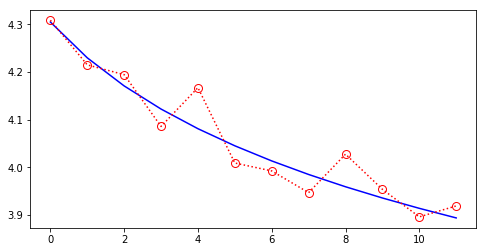

In [13]:
plt.rcParams['figure.figsize'] = (8, 4)
y_arps =  Arps(t,a_Di,a_logQi,a_b)
y_arps_test =  Arps(tt_test,a_Di,a_logQi,a_b)
plt.plot(y_arps,'b-')
plt.plot(data,'ro',fillstyle='none',**marker_style);

Confidence interval of the fit is calculated by drawing different samples from chains.

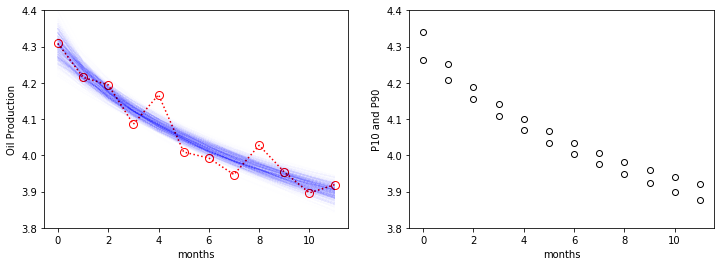

In [14]:
plt.rcParams['figure.figsize'] = (12, 4)
chains_to_plot=np.arange(1000)*9

fig = plt.figure()
aa = fig.add_subplot(1, 2, 1)
aa.plot(data,'ro',fillstyle='none',**marker_style)
kk=0
qq=np.zeros([len(chains_to_plot),len(t)])
for ii in chains_to_plot:
    qq[kk,:]=Arps(t,chain[ii,0],chain[ii,1],chain[ii,2])
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='Oil Production')
    
qq_p10=np.zeros(len(t))
qq_p90=np.zeros(len(t))
for tt in np.arange(0,12):
    sorted_qq=np.sort(qq[:,tt])
    ixL = np.floor(np.size(sorted_qq)*.1).astype(int) ## lower index
    ixU = np.floor(np.size(sorted_qq)*.9).astype(int) ## upper index
    qq_p10[tt]=sorted_qq[ixL]
    qq_p90[tt]=sorted_qq[ixU]
aa = fig.add_subplot(1, 2, 2)
aa.plot(qq_p10,'ko',fillstyle='none')
aa.plot(qq_p90,'ko',fillstyle='none')
aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='P10 and P90');

Individual parameter distributions are shown below

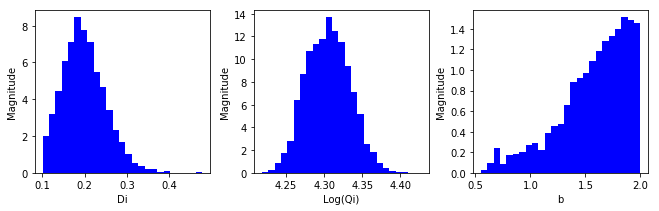

In [15]:
plt.rcParams['figure.figsize'] = (11, 3)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

ax = fig.add_subplot(1, 3, 1)
ax.hist(chain[:,0],25,density=True,color='blue');
ax.set(xlabel='Di', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 2)
ax.hist(chain[:,1],25,density=True,color='blue');
ax.set(xlabel='Log(Qi)', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 3)
ax.hist(chain[:,2],25,density=True,color='blue');
ax.set(xlabel='b', ylabel='Magnitude'); 

In [ ]:
#Testing
plt.rcParams['figure.figsize'] = (8, 4)
chains_to_plot=np.arange(1000)*9
kk=0
qq=np.zeros([len(chains_to_plot),24])
for ii in chains_to_plot:
    qq[kk,:]=Arps(tt_test,chain[ii,0],chain[ii,1],chain[ii,2])
    kk+=1

qq_p10=np.zeros(24)
qq_p90=np.zeros(24)
for tt in np.arange(0,24):
    sorted_qq=np.sort(qq[:,tt])
    ixL = np.floor(np.size(sorted_qq)*0.1).astype(int) ## lower index
    ixU = np.floor(np.size(sorted_qq)*0.9).astype(int) ## upper index
    qq_p10[tt]=sorted_qq[ixL]
    qq_p90[tt]=sorted_qq[ixU]

fig = plt.figure()
aa = plt.axes()
aa.plot(qq_p10,'r-.',label='P10')
aa.plot(qq_p90,'b-.',label='P90')
aa.set(xlabel='months', ylabel='P10 and P90',title='Test and train data');
aa.plot(data,'ro',fillstyle='none',**marker_style,label='train data')
aa.plot(np.linspace(12,23,12),np.log10(cur[12:24]),'ko',fillstyle='none',markersize=8,label='Test data' )
aa.legend(loc='upper right');

C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


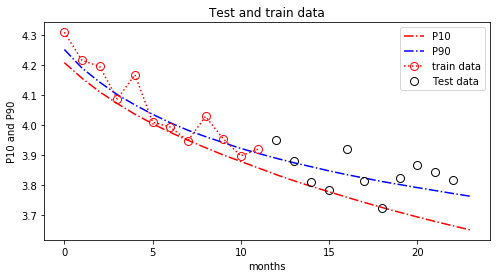

### Hyberbolic Transient Function
Corelation for Jacobi Theta function is provided below.
$$Equation to be added$$
In theta function model parameter $b$ from arps is further parameterized into $b_f$ and $t_{elf}$.

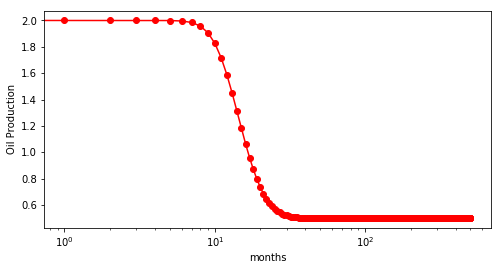

In [17]:
t_elf = 12
bf = 0.5
t_test = np.linspace(0,1000,500)
c = np.exp(0.57722)/(1.175*t_elf)
b = 2-(2-bf)*np.exp(-np.exp(-c*(t_test-t_elf)+np.exp(0.57722)))
plt.rcParams['figure.figsize'] = (8, 4)
fig = plt.figure();aa = plt.axes();
aa.semilogx(b,'ro-');
aa.set(xlabel='months', ylabel='Oil Production');  

Jacobi Theta function

In [18]:
def post2(Di,logQi,bf,t_elf,sigma,t,data):
    c = np.exp(0.57722)/(1.175*t_elf)
    b = 2-(2-bf)*np.exp(-np.exp(-c*(t-t_elf)+np.exp(0.57722)))
    like = np.prod(np.exp(-np.power(Arps(t,Di,logQi,b)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [19]:
logQi = data[0]
bf = 0.5
t_elf = 24
Niter = 100000
chain = np.zeros((Niter,4))
chain[0,0] = Di # Initialize the chain with first guess
chain[0,1] = logQi
chain[0,2] = bf 
chain[0,3] = t_elf

In [20]:
for ii in np.arange(Niter-1):
        if ii%50000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        bf    = chain[ii,2] 
        t_elf = chain[ii,3]
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        bf_p    = bf + np.random.normal(loc=0.0,scale=0.1,size=1)
        t_elf_p = t_elf + np.random.normal(loc=0.0,scale=0.1,size=1)
        
        if Di_p < 0.1 or Di_p>50 or bf_p<0 or bf_p>1 or t_elf_p<0 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post2(Di_p,logQi_p,bf_p,t_elf_p,sigma,t,data) / post2(Di,logQi,bf,t_elf,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = bf_p
            chain[ii+1,3] = t_elf_p
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter))

iteration 0
iteration 50000
Sampling finished at iteration 100000


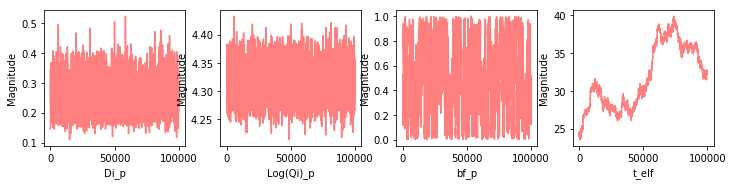

In [21]:
plt.rcParams['figure.figsize'] = (12, 2.5)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

ax = fig.add_subplot(1, 4, 1)
ax.plot(chain[:,0],color='r',alpha=.5);
ax.set(xlabel='Di_p', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 4, 2)
ax.plot(chain[:,1],color='r',alpha=.5);
ax.set(xlabel='Log(Qi)_p', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 4, 3)
ax.plot(chain[:,2],color='r',alpha=.5);
ax.set(xlabel='bf_p', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 4, 4)
ax.plot(chain[:,3],color='r',alpha=.5);
ax.set(xlabel='t_elf', ylabel='Magnitude'); 

In [22]:
chain = chain[10000:]#burnin
#np.size(chain[:,2])

### Hyperbolic Transient-Posterior Summaries
Mean value of the fitted parameters is as follows.

In [23]:
t_Di=round(np.mean(chain[:,0]),3)
t_logQi=round(np.mean(chain[:,1]),3)
t_bf=round(np.mean(chain[:,2]),3)
print('Mean of D     ={}'.format(t_Di))
print('Mean of logQi ={}'.format(t_logQi))
print('Mean of b     ={}'.format(t_bf))

Mean of D     =0.256
Mean of logQi =4.319
Mean of b     =0.501


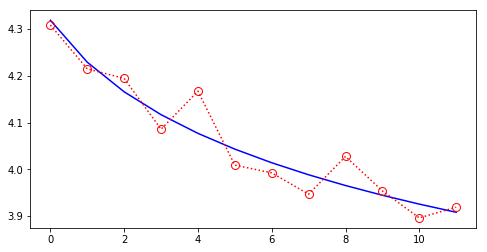

In [24]:
plt.rcParams['figure.figsize'] = (8, 4)
c = np.exp(0.57722)/(1.175*t_elf)
b = 2-(2-t_bf)*np.exp(-np.exp(-c*(t-t_elf)+np.exp(0.57722)))
y_trans =  Arps(t,t_Di,t_logQi,b)

c = np.exp(0.57722)/(1.175*24) ############t_elf=24
b = 2-(2-t_bf)*np.exp(-np.exp(-c*(tt_test-t_elf)+np.exp(0.57722)))
y_trans_test =  Arps(tt_test,t_Di,t_logQi,b)
plt.plot(y_trans,'b-')
plt.plot(data,'ro',fillstyle='none',**marker_style)
aa.set(xlabel='months', ylabel='Oil Production');  

Drawing from chains to develop confidence interval

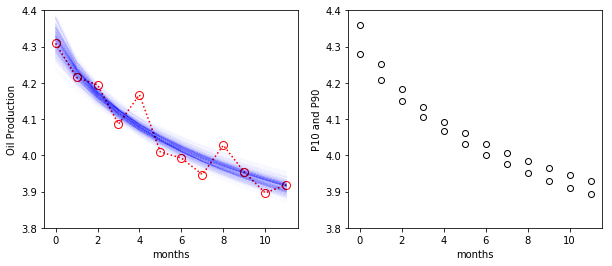

In [25]:
plt.rcParams['figure.figsize'] = (10, 4)

chains_to_plot=np.arange(1000)*9
fig = plt.figure()
aa = fig.add_subplot(1, 2, 1)
aa.plot(data,'ro',fillstyle='none',**marker_style)
#aa.plot(y_hat,'g-')
kk=0
qq=np.zeros([len(chains_to_plot),len(t)])
for ii in chains_to_plot:
    b = 2-(2-chain[ii,2])*np.exp(-np.exp(-c*(t-chain[ii,3])+np.exp(0.57722)))
    qq[kk,:]=Arps(t,chain[ii,0],chain[ii,1],b)
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='Oil Production')
    
qq_p10=np.zeros(len(t))
qq_p90=np.zeros(len(t))
for tt in np.arange(0,12):
    sorted_qq=np.sort(qq[:,tt])
    ixL = np.floor(np.size(sorted_qq)*.1).astype(int) ## lower index
    ixU = np.floor(np.size(sorted_qq)*.9).astype(int) ## upper index
    qq_p10[tt]=sorted_qq[ixL]
    qq_p90[tt]=sorted_qq[ixU]
aa = fig.add_subplot(1, 2, 2)
aa.plot(qq_p10,'ko',fillstyle='none')
aa.plot(qq_p90,'ko',fillstyle='none')
aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='P10 and P90');

Distribution of individual parameters

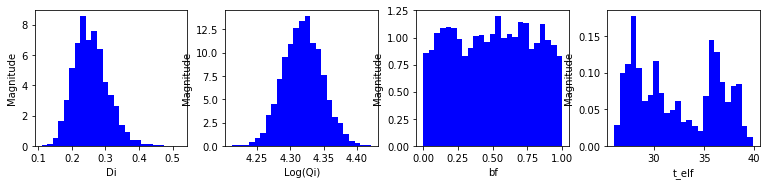

In [26]:
plt.rcParams['figure.figsize'] = (13, 2.5)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

ax = fig.add_subplot(1, 4, 1)
ax.hist(chain[:,0],25,density=True,color='blue');
ax.set(xlabel='Di', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 4, 2)
ax.hist(chain[:,1],25,density=True,color='blue');
ax.set(xlabel='Log(Qi)', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 4, 3)
ax.hist(chain[:,2],25,density=True,color='b');
ax.set(xlabel='bf', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 4, 4)
ax.hist(chain[:,3],25,density=True,color='b');
ax.set(xlabel='t_elf', ylabel='Magnitude'); 

### Jacobi Theta Function
Corelation for Jacobi Theta function is provided below.
$$Equation to be added$$

In [27]:
def Jacobi_theta(t,logQi,chi,eta):
    Qt = np.zeros(len(t))
    for i in range(len(t)):
        Qt[i] = logQi + np.log10(float(mp.jtheta(2,chi,np.exp(-eta*t[i]))))
    return Qt

In [28]:
def post(logQi,chi,eta,sigma,t,data):
    like = np.prod(np.exp(-np.power(Jacobi_theta(t,logQi,chi,eta)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [29]:
logQi = data[0]
#logQi = 4
chi = 0.5
eta = 0.5
t_fine = np.linspace(0.01,11,119)
t = np.linspace(1,12,12)
Niter = 10000
chain = np.zeros((Niter,3))
chain[0,0] = logQi# Initialize the chain with first guess
chain[0,1] = chi
chain[0,2] = eta

In [30]:
for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        logQi    = chain[ii,0] 
        chi      = chain[ii,1] 
        eta      = chain[ii,2] 
        chi_p    = float(chi + np.random.normal(loc=0.0,scale=0.1,size=1))
        logQi_p  = float(logQi + np.random.normal(loc=0.0,scale=0.1,size=1))
        eta_p     = float(eta + np.random.normal(loc=0.0,scale=0.1,size=1))
        
        if chi_p < 0 or eta_p<0 or logQi_p > 7 or logQi_p< -2:
            chain[ii+1,:] = chain[ii,:]
        elif (post(logQi_p,chi_p,eta_p,sigma,t,data) / post(logQi,chi,eta,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = logQi_p 
            chain[ii+1,1] = chi_p 
            chain[ii+1,2] = eta_p 
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter)) 

iteration 0


C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Sampling finished at iteration 10000


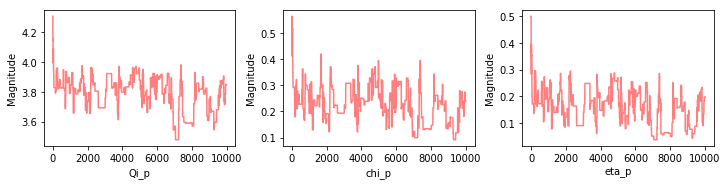

In [31]:
plt.rcParams['figure.figsize'] = (12, 2.5)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

ax = fig.add_subplot(1, 3, 1)
ax.plot(chain[:,0],color='r',alpha=.5);
ax.set(xlabel='Qi_p', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 2)
ax.plot(chain[:,1],color='r',alpha=.5);
ax.set(xlabel='chi_p', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 3)
ax.plot(chain[:,2],color='r',alpha=.5);
ax.set(xlabel='eta_p', ylabel='Magnitude'); 

In [32]:
chain = chain[1000:]#burnin
#np.size(chain[:,2])

In [33]:
logQi_t=round(np.mean(chain[:,0]),3)
chi=round(np.mean(chain[:,1]),3)
eta=round(np.mean(chain[:,2]),3)
print('Mean of D     ={}'.format(logQi_t))
print('Mean of logQi ={}'.format(chi))
print('Mean of b     ={}'.format(eta))

Mean of D     =3.785
Mean of logQi =0.226
Mean of b     =0.154


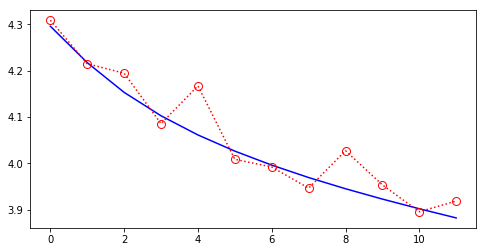

In [34]:
plt.rcParams['figure.figsize'] = (8, 4)
y_theta =  Jacobi_theta(t,logQi_t,chi,eta)
y_theta_test =  Jacobi_theta(tt_test,logQi_t,chi,eta)
plt.plot(y_theta,'b-')
plt.plot(data,'ro',fillstyle='none',**marker_style)
aa.set(xlabel='months', ylabel='Oil Production'); 


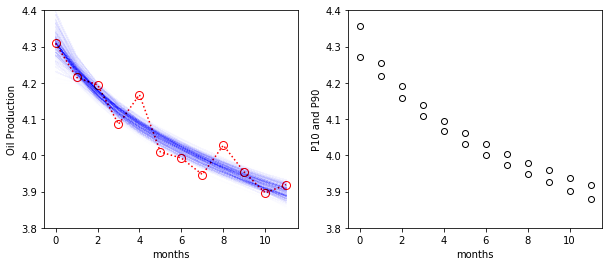

In [35]:
plt.rcParams['figure.figsize'] = (10, 4)

chains_to_plot=np.arange(1000)*9
fig = plt.figure()
aa = fig.add_subplot(1, 2, 1)
aa.plot(data,'ro',fillstyle='none',**marker_style)
kk=0
qq=np.zeros([len(chains_to_plot),len(t)])
for ii in chains_to_plot:
    qq[kk,:]=Jacobi_theta(t,chain[ii,0],chain[ii,1],chain[ii,2])
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='Oil Production')
    
qq_p10=np.zeros(len(t))
qq_p90=np.zeros(len(t))
for tt in np.arange(0,12):
    sorted_qq=np.sort(qq[:,tt])
    ixL = np.floor(np.size(sorted_qq)*.1).astype(int) ## lower index
    ixU = np.floor(np.size(sorted_qq)*.9).astype(int) ## upper index
    qq_p10[tt]=sorted_qq[ixL]
    qq_p90[tt]=sorted_qq[ixU]
aa = fig.add_subplot(1, 2, 2)
aa.plot(qq_p10,'ko',fillstyle='none')
aa.plot(qq_p90,'ko',fillstyle='none')
aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='P10 and P90');

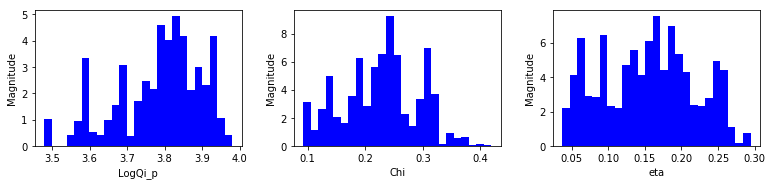

In [36]:
plt.rcParams['figure.figsize'] = (13, 2.5)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.25)

ax = fig.add_subplot(1, 3, 1)
ax.hist(chain[:,0],25,density=True,color='blue');
ax.set(xlabel='LogQi_p', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 2)
ax.hist(chain[:,1],25,density=True,color='blue');
ax.set(xlabel='Chi', ylabel='Magnitude'); 

ax = fig.add_subplot(1, 3, 3)
ax.hist(chain[:,2],25,density=True,color='b');
ax.set(xlabel='eta', ylabel='Magnitude'); 

### Model Testing
12 months of data was used for fitting. Remaining months of data is used for testing. 

### Validation
Curve parameters are fitting using Least Square for validation. Usually MCMC is applied where sampling from poterior is possible or closed form corelations are not available. 

In [37]:
Di_bf = 0.5
logQi_bf = 4
b = 0.5

params, params_covariance = optimize.curve_fit(Arps, t, data,
                                               p0=[0.22,4.3,2])
y_hat = Arps(tt_test,params[0],params[1],params[2])
#sigma = np.sqrt(np.sum(np.power(data-y_hat,2))/(len(tt_test)-3))
#print('Variance is {}'.format(sigma))

C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


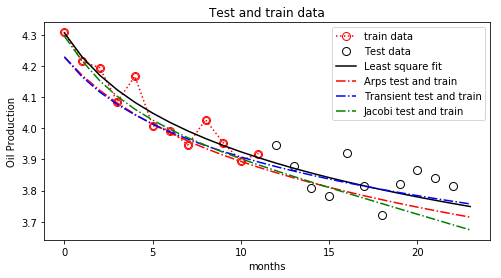

In [38]:
#testing and RSS
plt.rcParams['figure.figsize'] = (8, 4)

fig = plt.figure()
aa = plt.axes()

aa.set(xlabel='months', ylabel='P10 and P90',title='Test and train data');
aa.plot(data,'ro',fillstyle='none',**marker_style,label='train data')
aa.plot(np.linspace(12,23,12),np.log10(cur[12:24]),'ko',fillstyle='none',markersize=8,label='Test data' )
aa.plot(data,'ro',fillstyle='none');
aa.plot(y_hat,'k-',label='Least square fit');
aa.plot(y_arps_test,'r-.',label='Arps test and train')
aa.plot(y_trans_test,'b-.',label='Transient test and train')
aa.plot(y_theta_test,'g-.',label='Jacobi test and train')
aa.set(xlabel='months', ylabel='Oil Production');
aa.legend(loc='upper right');

In [41]:
datt=np.log10((oil_array[3][:23]))

In [42]:
rms_y_hat_train=np.mean(np.sqrt((datt[:11]-y_hat[:11])**2))*100
print('rms_y_hat_train is {}'.format(rms_y_hat_train))
rms_y_hat_test=np.mean(np.sqrt((datt[11:23]-y_hat[11:23])**2))*100
print('rms_y_hat_test is {}'.format(rms_y_hat_test))

rms_y_arps_train=np.mean(np.sqrt((datt[:11]-y_arps_test[:11])**2))*100
print('rms_y_arps_train is {}'.format(rms_y_arps_train))
rms_y_arps_test=np.mean(np.sqrt((datt[11:23]-y_arps_test[11:23])**2))*100
print('rms_y_arps_test is {}'.format(rms_y_arps_test))

rms_y_trans_train=np.mean(np.sqrt((datt[:11]-y_trans_test[:11])**2))*100
print('rms_y_trans_train is {}'.format(rms_y_trans_train))
rms_y_trans_test=np.mean(np.sqrt((datt[11:23]-y_trans_test[11:23])**2))*100
print('rms_y_trans_test is {}'.format(rms_y_trans_test))

rms_y_theta_train=np.mean(np.sqrt((datt[:11]-y_theta_test[:11])**2))*100
print('rms_y_theta_train is {}'.format(rms_y_theta_train))
rms_y_theta_test=np.mean(np.sqrt((datt[11:23]-y_theta_test[11:23])**2))*100
print('rms_y_theta_test is {}'.format(rms_y_theta_test))



rms_y_hat_train is 3.3666463648392404
rms_y_hat_test is 5.0663105390638155
rms_y_arps_train is 4.366208345304972
rms_y_arps_test is 6.645095449830481
rms_y_trans_train is 4.454599355053852
rms_y_trans_test is 5.116737326711266
rms_y_theta_train is 3.1150995866348894
rms_y_theta_test is 7.3626301129290255
